# Machine Learning for Classification

We'll use logistic regression to predict churn

## 1. Data preparation

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('Telco-Customer-Churn.csv')
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [3]:
df.columns = df.columns.str.lower().str.replace(' ', '_')

categorical_columns = list(df.dtypes[df.dtypes == 'object'].index)

for c in categorical_columns:
    df[c] = df[c].str.lower().str.replace(' ', '_')

In [4]:
df.head().T

,0,1,2,3,4
customerid,7590-vhveg,5575-gnvde,3668-qpybk,7795-cfocw,9237-hqitu
gender,female,male,male,male,female
seniorcitizen,0,0,0,0,0
partner,yes,no,no,no,no
dependents,no,no,no,no,no
tenure,1,34,2,45,2
phoneservice,no,yes,yes,no,yes
multiplelines,no_phone_service,no,no,no_phone_service,no
internetservice,dsl,dsl,dsl,dsl,fiber_optic
onlinesecurity,no,yes,yes,yes,no


In [5]:
df.dtypes

customerid           object
gender               object
seniorcitizen         int64
partner              object
dependents           object
tenure                int64
phoneservice         object
multiplelines        object
internetservice      object
onlinesecurity       object
onlinebackup         object
deviceprotection     object
techsupport          object
streamingtv          object
streamingmovies      object
contract             object
paperlessbilling     object
paymentmethod        object
monthlycharges      float64
totalcharges         object
churn                object
dtype: object

In [6]:
tc = pd.to_numeric(df.totalcharges, errors='coerce')

In [7]:
df.totalcharges = pd.to_numeric(df.totalcharges, errors='coerce')

In [8]:
df.totalcharges = df.totalcharges.fillna(0)

In [9]:
df.churn.head()

0     no
1     no
2    yes
3     no
4    yes
Name: churn, dtype: object

In [10]:
df.churn = (df.churn == 'yes').astype(int)

In [11]:
df.churn.head()

0    0
1    0
2    1
3    0
4    1
Name: churn, dtype: int32

## 2. Setting up the validation framework

- Perform the train/validation/test split with Scikit-Learn

In [12]:
from sklearn.model_selection import train_test_split

In [13]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

In [14]:
len(df_train), len(df_val), len(df_test)

(4225, 1409, 1409)

In [15]:
df_train

,customerid,gender,seniorcitizen,partner,dependents,tenure,phoneservice,multiplelines,internetservice,onlinesecurity,...,deviceprotection,techsupport,streamingtv,streamingmovies,contract,paperlessbilling,paymentmethod,monthlycharges,totalcharges,churn
3897,8015-ihcgw,female,0,yes,yes,72,yes,yes,fiber_optic,yes,...,yes,yes,yes,yes,two_year,yes,electronic_check,115.50,8425.15,0
1980,1960-uycnn,male,0,no,no,10,yes,yes,fiber_optic,no,...,yes,no,no,yes,month-to-month,yes,electronic_check,95.25,1021.55,0
6302,9250-wypll,female,0,no,no,5,yes,yes,fiber_optic,no,...,no,no,no,no,month-to-month,no,electronic_check,75.55,413.65,1
727,6786-obwqr,female,0,yes,yes,5,yes,no,fiber_optic,no,...,no,no,yes,no,month-to-month,yes,electronic_check,80.85,356.10,0
5104,1328-euzhc,female,0,yes,no,18,yes,no,no,no_internet_service,...,no_internet_service,no_internet_service,no_internet_service,no_internet_service,two_year,no,mailed_check,20.10,370.50,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3774,1309-xgfsn,male,1,yes,yes,52,yes,yes,dsl,no,...,yes,no,yes,yes,one_year,yes,electronic_check,80.85,4079.55,0
6108,4819-hjpiw,male,0,no,no,18,no,no_phone_service,dsl,no,...,no,no,no,no,month-to-month,no,mailed_check,25.15,476.80,0
1530,3703-vavcl,male,0,yes,yes,2,yes,no,fiber_optic,no,...,yes,yes,no,yes,month-to-month,no,credit_card_(automatic),90.00,190.05,1
3701,3812-lrzir,female,0,yes,yes,27,yes,yes,no,no_internet_service,...,no_internet_service,no_internet_service,no_internet_service,no_internet_service,two_year,no,electronic_check,24.50,761.95,0


In [16]:
df_train.reset_index(drop=True)

,customerid,gender,seniorcitizen,partner,dependents,tenure,phoneservice,multiplelines,internetservice,onlinesecurity,...,deviceprotection,techsupport,streamingtv,streamingmovies,contract,paperlessbilling,paymentmethod,monthlycharges,totalcharges,churn
0,8015-ihcgw,female,0,yes,yes,72,yes,yes,fiber_optic,yes,...,yes,yes,yes,yes,two_year,yes,electronic_check,115.50,8425.15,0
1,1960-uycnn,male,0,no,no,10,yes,yes,fiber_optic,no,...,yes,no,no,yes,month-to-month,yes,electronic_check,95.25,1021.55,0
2,9250-wypll,female,0,no,no,5,yes,yes,fiber_optic,no,...,no,no,no,no,month-to-month,no,electronic_check,75.55,413.65,1
3,6786-obwqr,female,0,yes,yes,5,yes,no,fiber_optic,no,...,no,no,yes,no,month-to-month,yes,electronic_check,80.85,356.10,0
4,1328-euzhc,female,0,yes,no,18,yes,no,no,no_internet_service,...,no_internet_service,no_internet_service,no_internet_service,no_internet_service,two_year,no,mailed_check,20.10,370.50,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4220,1309-xgfsn,male,1,yes,yes,52,yes,yes,dsl,no,...,yes,no,yes,yes,one_year,yes,electronic_check,80.85,4079.55,0
4221,4819-hjpiw,male,0,no,no,18,no,no_phone_service,dsl,no,...,no,no,no,no,month-to-month,no,mailed_check,25.15,476.80,0
4222,3703-vavcl,male,0,yes,yes,2,yes,no,fiber_optic,no,...,yes,yes,no,yes,month-to-month,no,credit_card_(automatic),90.00,190.05,1
4223,3812-lrzir,female,0,yes,yes,27,yes,yes,no,no_internet_service,...,no_internet_service,no_internet_service,no_internet_service,no_internet_service,two_year,no,electronic_check,24.50,761.95,0


In [17]:
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [18]:
y_train = df_train.churn.values
y_val = df_val.churn.values
y_test = df_test.churn.values

del df_train['churn']
del df_val['churn']
del df_test['churn']

## 3. Exploratory Data Analysis

In [19]:
df_full_train = df_full_train.reset_index(drop=True)

In [20]:
df_full_train

,customerid,gender,seniorcitizen,partner,dependents,tenure,phoneservice,multiplelines,internetservice,onlinesecurity,...,deviceprotection,techsupport,streamingtv,streamingmovies,contract,paperlessbilling,paymentmethod,monthlycharges,totalcharges,churn
0,5442-pptjy,male,0,yes,yes,12,yes,no,no,no_internet_service,...,no_internet_service,no_internet_service,no_internet_service,no_internet_service,two_year,no,mailed_check,19.70,258.35,0
1,6261-rcvns,female,0,no,no,42,yes,no,dsl,yes,...,yes,yes,no,yes,one_year,no,credit_card_(automatic),73.90,3160.55,1
2,2176-osjuv,male,0,yes,no,71,yes,yes,dsl,yes,...,no,yes,no,no,two_year,no,bank_transfer_(automatic),65.15,4681.75,0
3,6161-erdgd,male,0,yes,yes,71,yes,yes,dsl,yes,...,yes,yes,yes,yes,one_year,no,electronic_check,85.45,6300.85,0
4,2364-ufrom,male,0,no,no,30,yes,no,dsl,yes,...,no,yes,yes,no,one_year,no,electronic_check,70.40,2044.75,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5629,0781-lkxbr,male,1,no,no,9,yes,yes,fiber_optic,no,...,yes,no,yes,yes,month-to-month,yes,electronic_check,100.50,918.60,1
5630,3507-gasnp,male,0,no,yes,60,yes,no,no,no_internet_service,...,no_internet_service,no_internet_service,no_internet_service,no_internet_service,two_year,no,mailed_check,19.95,1189.90,0
5631,8868-wozgu,male,0,no,no,28,yes,yes,fiber_optic,no,...,yes,no,yes,yes,month-to-month,yes,electronic_check,105.70,2979.50,1
5632,1251-krreg,male,0,no,no,2,yes,yes,dsl,no,...,no,no,no,no,month-to-month,yes,mailed_check,54.40,114.10,1


In [21]:
df_full_train.isnull().sum()

customerid          0
gender              0
seniorcitizen       0
partner             0
dependents          0
tenure              0
phoneservice        0
multiplelines       0
internetservice     0
onlinesecurity      0
onlinebackup        0
deviceprotection    0
techsupport         0
streamingtv         0
streamingmovies     0
contract            0
paperlessbilling    0
paymentmethod       0
monthlycharges      0
totalcharges        0
churn               0
dtype: int64

In [22]:
# Target variable

df_full_train.churn.value_counts(normalize=True)

churn
0    0.730032
1    0.269968
Name: proportion, dtype: float64

In [23]:
df_full_train.churn.mean()

0.26996805111821087

In [24]:
def grab_col_names(dataframe, cat_th=10, car_th=20):
    """

    Provides the names of categorical, numerical, and categorical but cardinal variables in the dataset.
    Note: Numerical-looking categorical variables are also included in the categorical variables.

    Parameters
    ------
        dataframe: dataframe
            The dataframe from which variable names are to be extracted.
        cat_th: int, optional
            Class threshold value for numerical-looking categorical variables.
        car_th: int, optional
            Class threshold value for categorical but cardinal variables.

    Returns
    ------
        cat_cols: list
            List of categorical variable names.
        num_cols: list
            List of numerical variable names.
        cat_but_car: list
            List of categorical-looking cardinal variable names.

    Examples
    ------
        import seaborn as sns
        df = sns.load_dataset("iris")
        print(grab_col_names(df))

    Notes
    ------
        cat_cols + num_cols + cat_but_car = total number of variables.
        Numerical-looking categorical variables are included in cat_cols.
        The sum of the 3 lists returned is equal to the total number of variables: cat_cols + num_cols + cat_but_car = total number of variables.

    """

    # cat_cols, cat_but_car
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]
    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and
                   dataframe[col].dtypes != "O"]
    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and
                   dataframe[col].dtypes == "O"]
    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    # num_cols
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]
    num_cols = [col for col in num_cols if col not in num_but_cat]

    print(f"Observations: {dataframe.shape[0]}")
    print(f"Variables: {dataframe.shape[1]}")
    print(f'cat_cols: {len(cat_cols)}')
    print(f'num_cols: {len(num_cols)}')
    print(f'cat_but_car: {len(cat_but_car)}')
    print(f'num_but_cat: {len(num_but_cat)}')
    return cat_cols, num_cols, cat_but_car

In [25]:
cat_cols, num_cols, cat_but_car = grab_col_names(df)

Observations: 7043
Variables: 21
cat_cols: 17
num_cols: 3
cat_but_car: 1
num_but_cat: 2


In [26]:
num_cols

['tenure', 'monthlycharges', 'totalcharges']

In [27]:
cat_but_car

['customerid']

In [28]:
cat_cols

['gender',
 'partner',
 'dependents',
 'phoneservice',
 'multiplelines',
 'internetservice',
 'onlinesecurity',
 'onlinebackup',
 'deviceprotection',
 'techsupport',
 'streamingtv',
 'streamingmovies',
 'contract',
 'paperlessbilling',
 'paymentmethod',
 'seniorcitizen',
 'churn']

In [29]:
df_full_train[cat_cols].nunique()

gender              2
partner             2
dependents          2
phoneservice        2
multiplelines       3
internetservice     3
onlinesecurity      3
onlinebackup        3
deviceprotection    3
techsupport         3
streamingtv         3
streamingmovies     3
contract            3
paperlessbilling    2
paymentmethod       4
seniorcitizen       2
churn               2
dtype: int64

## 4. Feature importance: Churn rate and risk ratio

### Churn rate

In [30]:
df_full_train.head()

,customerid,gender,seniorcitizen,partner,dependents,tenure,phoneservice,multiplelines,internetservice,onlinesecurity,...,deviceprotection,techsupport,streamingtv,streamingmovies,contract,paperlessbilling,paymentmethod,monthlycharges,totalcharges,churn
0,5442-pptjy,male,0,yes,yes,12,yes,no,no,no_internet_service,...,no_internet_service,no_internet_service,no_internet_service,no_internet_service,two_year,no,mailed_check,19.70,258.35,0
1,6261-rcvns,female,0,no,no,42,yes,no,dsl,yes,...,yes,yes,no,yes,one_year,no,credit_card_(automatic),73.90,3160.55,1
2,2176-osjuv,male,0,yes,no,71,yes,yes,dsl,yes,...,no,yes,no,no,two_year,no,bank_transfer_(automatic),65.15,4681.75,0
3,6161-erdgd,male,0,yes,yes,71,yes,yes,dsl,yes,...,yes,yes,yes,yes,one_year,no,electronic_check,85.45,6300.85,0
4,2364-ufrom,male,0,no,no,30,yes,no,dsl,yes,...,no,yes,yes,no,one_year,no,electronic_check,70.40,2044.75,0


In [31]:
churn_female = df_full_train[df_full_train.gender == 'female'].churn.mean()
churn_female

0.27682403433476394

In [32]:
churn_male = df_full_train[df_full_train.gender == 'male'].churn.mean()
churn_male

0.2632135306553911

In [33]:
##################    Categorical Variable Analysis    #################

def cat_summary(dataframe, col_name, plot=False):
    print(pd.DataFrame({col_name: dataframe[col_name].value_counts(),
                        "Ratio": 100 * dataframe[col_name].value_counts() / len(dataframe)}))
    print("####################################################")
    if plot:
        sns.countplot(x=dataframe[col_name], data=dataframe)
        plt.show()
        
for col in cat_cols:
    cat_summary(df, col)

        gender     Ratio
gender                  
male      3555  50.47565
female    3488  49.52435
####################################################
         partner     Ratio
partner                   
no          3641  51.69672
yes         3402  48.30328
####################################################
            dependents      Ratio
dependents                       
no                4933  70.041176
yes               2110  29.958824
####################################################
              phoneservice      Ratio
phoneservice                         
yes                   6361  90.316626
no                     682   9.683374
####################################################
                  multiplelines      Ratio
multiplelines                             
no                         3390  48.132898
yes                        2971  42.183729
no_phone_service            682   9.683374
####################################################
                 interne

In [34]:
global_churn = df_full_train.churn.mean()
global_churn

0.26996805111821087

In [35]:
global_churn - churn_female

-0.006855983216553063

In [36]:
global_churn - churn_male

0.006754520462819769

In [37]:
df_full_train.partner.value_counts()

partner
no     2932
yes    2702
Name: count, dtype: int64

In [38]:
churn_partner = df_full_train[df_full_train.partner == 'yes'].churn.mean()
churn_partner

0.20503330866025166

In [39]:
global_churn - churn_partner

0.06493474245795922

In [40]:
churn_no_partner = df_full_train[df_full_train.partner == 'no'].churn.mean()
churn_no_partner

0.3298090040927694

In [41]:
global_churn - churn_no_partner

-0.05984095297455855

### Risk ratio

In [42]:
churn_no_partner / global_churn

1.2216593879412643

In [43]:
churn_partner / global_churn

0.7594724924338315

```sql
SELECT
    gender,
    AVG(churn),
    AVG(churn) - global_churn AS diff,
    AVG(churn) / global_churn AS risk
FROM
    data
GROUP BY
    gender;


In [44]:
from IPython.display import display

In [46]:
for c in cat_cols:
    print(c)
    df_group = df_full_train.groupby(c).churn.agg(['mean', 'count'])
    df_group['diff'] = df_group['mean'] - global_churn
    df_group['risk'] = df_group['mean'] / global_churn
    display(df_group)
    print()
    print()

gender


,mean,count,diff,risk
gender,,,,
female,0.276824,2796,0.006856,1.025396
male,0.263214,2838,-0.006755,0.974980




partner


,mean,count,diff,risk
partner,,,,
no,0.329809,2932,0.059841,1.221659
yes,0.205033,2702,-0.064935,0.759472




dependents


,mean,count,diff,risk
dependents,,,,
no,0.313760,3968,0.043792,1.162212
yes,0.165666,1666,-0.104302,0.613651




phoneservice


,mean,count,diff,risk
phoneservice,,,,
no,0.241316,547,-0.028652,0.893870
yes,0.273049,5087,0.003081,1.011412




multiplelines


,mean,count,diff,risk
multiplelines,,,,
no,0.257407,2700,-0.012561,0.953474
no_phone_service,0.241316,547,-0.028652,0.893870
yes,0.290742,2387,0.020773,1.076948




internetservice


,mean,count,diff,risk
internetservice,,,,
dsl,0.192347,1934,-0.077621,0.712482
fiber_optic,0.425171,2479,0.155203,1.574895
no,0.077805,1221,-0.192163,0.288201




onlinesecurity


,mean,count,diff,risk
onlinesecurity,,,,
no,0.420921,2801,0.150953,1.559152
no_internet_service,0.077805,1221,-0.192163,0.288201
yes,0.153226,1612,-0.116742,0.567570




onlinebackup


,mean,count,diff,risk
onlinebackup,,,,
no,0.404323,2498,0.134355,1.497672
no_internet_service,0.077805,1221,-0.192163,0.288201
yes,0.217232,1915,-0.052736,0.804660




deviceprotection


,mean,count,diff,risk
deviceprotection,,,,
no,0.395875,2473,0.125907,1.466379
no_internet_service,0.077805,1221,-0.192163,0.288201
yes,0.230412,1940,-0.039556,0.853480




techsupport


,mean,count,diff,risk
techsupport,,,,
no,0.418914,2781,0.148946,1.551717
no_internet_service,0.077805,1221,-0.192163,0.288201
yes,0.159926,1632,-0.110042,0.592390




streamingtv


,mean,count,diff,risk
streamingtv,,,,
no,0.342832,2246,0.072864,1.269897
no_internet_service,0.077805,1221,-0.192163,0.288201
yes,0.302723,2167,0.032755,1.121328




streamingmovies


,mean,count,diff,risk
streamingmovies,,,,
no,0.338906,2213,0.068938,1.255358
no_internet_service,0.077805,1221,-0.192163,0.288201
yes,0.307273,2200,0.037305,1.138182




contract


,mean,count,diff,risk
contract,,,,
month-to-month,0.431701,3104,0.161733,1.599082
one_year,0.120573,1186,-0.149395,0.446621
two_year,0.028274,1344,-0.241694,0.104730




paperlessbilling


,mean,count,diff,risk
paperlessbilling,,,,
no,0.172071,2313,-0.097897,0.637375
yes,0.338151,3321,0.068183,1.252560




paymentmethod


,mean,count,diff,risk
paymentmethod,,,,
bank_transfer_(automatic),0.168171,1219,-0.101797,0.622928
credit_card_(automatic),0.164339,1217,-0.105630,0.608733
electronic_check,0.455890,1893,0.185922,1.688682
mailed_check,0.193870,1305,-0.076098,0.718121




seniorcitizen


,mean,count,diff,risk
seniorcitizen,,,,
0,0.242270,4722,-0.027698,0.897403
1,0.413377,912,0.143409,1.531208




churn


,mean,count,diff,risk
churn,,,,
0,0.0,4113,-0.269968,0.000000
1,1.0,1521,0.730032,3.704142


## 5. Feature importance: Mutual information

Mutual information is a concept from information theory, which measures how much we can learn about one variable if we know the value of another. 

- https://en.wikipedia.org/wiki/Mutual_information

Classes, functions, and methods:

- mutual_info_score(x, y) - Scikit-Learn class for calculating the mutual information between the x target variable and y feature.

- df[x].apply(y) - apply a y function to the x series of the df dataframe.

- df.sort_values(ascending=False).to_frame(name='x') - sort values in an ascending order and called the column as x.

In [47]:
from sklearn.metrics import mutual_info_score

In [48]:
mutual_info_score(df_full_train.churn, df_full_train.contract)

0.0983203874041556

In [49]:
mutual_info_score(df_full_train.gender, df_full_train.churn)

0.0001174846211139946

In [50]:
mutual_info_score(df_full_train.contract, df_full_train.churn)

0.0983203874041556

In [51]:
mutual_info_score(df_full_train.partner, df_full_train.churn)

0.009967689095399745

In [54]:
cat_cols = [col for col in cat_cols if col != 'churn']

In [56]:
def mutual_info_churn_score(series):
    return mutual_info_score(series, df_full_train.churn)

In [57]:
mi = df_full_train[cat_cols].apply(mutual_info_churn_score)
mi.sort_values(ascending=False)

contract            0.098320
onlinesecurity      0.063085
techsupport         0.061032
internetservice     0.055868
onlinebackup        0.046923
deviceprotection    0.043453
paymentmethod       0.043210
streamingtv         0.031853
streamingmovies     0.031581
paperlessbilling    0.017589
dependents          0.012346
partner             0.009968
seniorcitizen       0.009410
multiplelines       0.000857
phoneservice        0.000229
gender              0.000117
dtype: float64

## 6. Feature importance: Correlation

How about numerical columns?

- Correlation coefficient - https://en.wikipedia.org/wiki/Pearson_correlation_coefficient

In [58]:
df_full_train.tenure.max()

72

In [59]:
df_full_train[num_cols].corrwith(df_full_train.churn).abs()

tenure            0.351885
monthlycharges    0.196805
totalcharges      0.196353
dtype: float64

In [60]:
df_full_train[df_full_train.tenure <= 2].churn.mean()

0.5953420669577875

In [61]:
df_full_train[(df_full_train.tenure > 2) & (df_full_train.tenure <= 12)].churn.mean()

0.3994413407821229

In [62]:
df_full_train[df_full_train.tenure > 12].churn.mean()

0.17634908339788277

In [63]:
df_full_train[df_full_train.monthlycharges <= 20].churn.mean()

0.08795411089866156

In [64]:
df_full_train[(df_full_train.monthlycharges > 20) & (df_full_train.monthlycharges <= 50)].churn.mean()

0.18340943683409436

In [65]:
df_full_train[df_full_train.monthlycharges > 50].churn.mean()

0.32499341585462205

## 7. One-hot encoding

In [66]:
from sklearn.feature_extraction import DictVectorizer

In [67]:
dv = DictVectorizer(sparse=False)

train_dict = df_train[cat_cols + num_cols].to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

val_dict = df_val[cat_cols + num_cols].to_dict(orient='records')
X_val = dv.transform(val_dict)

## 8. Logistic Regression

In [68]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

In [69]:
z = np.linspace(-7, 7, 51)

In [70]:
sigmoid(10000)

1.0

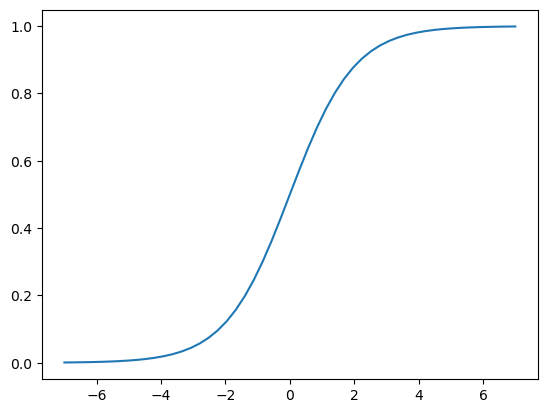

In [71]:
plt.plot(z, sigmoid(z))

In [72]:
def linear_regression(xi):
    result = w0
    
    for j in range(len(w)):
        result = result + xi[j] * w[j]
        
    return result

In [73]:
def logistic_regression(xi):
    score = w0
    
    for j in range(len(w)):
        score = score + xi[j] * w[j]
        
    result = sigmoid(score)
    return result

## 9. Training logistic regression with Scikit-Learn

In [75]:
from sklearn.linear_model import LogisticRegression

In [80]:
model = LogisticRegression(solver='lbfgs')
model.fit(X_train, y_train)

LogisticRegression()

In [81]:
model.intercept_[0]

-0.10899934810665589

In [82]:
model.coef_[0].round(3)

array([ 0.475, -0.175, -0.408, -0.03 , -0.078,  0.063, -0.089, -0.081,
       -0.034, -0.073, -0.335,  0.317, -0.089,  0.004, -0.258,  0.141,
        0.009,  0.063, -0.089, -0.081,  0.266, -0.089, -0.284, -0.231,
        0.124, -0.166,  0.058, -0.087, -0.032,  0.071, -0.059,  0.141,
       -0.249,  0.216, -0.12 , -0.089,  0.102, -0.071, -0.089,  0.052,
        0.213, -0.089, -0.232, -0.07 ,  0.   ])

In [83]:
y_pred = model.predict_proba(X_val)[:, 1]

In [84]:
churn_decision = (y_pred >= 0.5)

In [85]:
(y_val == churn_decision).mean()

0.8034066713981547

In [86]:
df_pred = pd.DataFrame()
df_pred['probability'] = y_pred
df_pred['prediction'] = churn_decision.astype(int)
df_pred['actual'] = y_val

In [87]:
df_pred['correct'] = df_pred.prediction == df_pred.actual

In [88]:
df_pred

,probability,prediction,actual,correct
0,0.008985,0,0,True
1,0.204673,0,0,True
2,0.212393,0,0,True
3,0.542987,1,1,True
4,0.213937,0,0,True
...,...,...,...,...
1404,0.313614,0,0,True
1405,0.039325,0,1,False
1406,0.136306,0,0,True
1407,0.799779,1,1,True


In [89]:
df_pred.correct.mean()

0.8034066713981547

In [90]:
churn_decision.astype(int)

array([0, 0, 0, ..., 0, 1, 1])

## 10. Model interpretation

- Look at the coefficients
- Train a smaller model with fewer features

In [91]:
a = [7, 14, 17]
b = 'abc'

In [92]:
dict(zip(a, b))

{7: 'a', 14: 'b', 17: 'c'}

In [93]:
dict(zip(dv.get_feature_names_out(), model.coef_[0].round(3)))

{'contract=month-to-month': 0.475,
 'contract=one_year': -0.175,
 'contract=two_year': -0.408,
 'dependents=no': -0.03,
 'dependents=yes': -0.078,
 'deviceprotection=no': 0.063,
 'deviceprotection=no_internet_service': -0.089,
 'deviceprotection=yes': -0.081,
 'gender=female': -0.034,
 'gender=male': -0.073,
 'internetservice=dsl': -0.335,
 'internetservice=fiber_optic': 0.317,
 'internetservice=no': -0.089,
 'monthlycharges': 0.004,
 'multiplelines=no': -0.258,
 'multiplelines=no_phone_service': 0.141,
 'multiplelines=yes': 0.009,
 'onlinebackup=no': 0.063,
 'onlinebackup=no_internet_service': -0.089,
 'onlinebackup=yes': -0.081,
 'onlinesecurity=no': 0.266,
 'onlinesecurity=no_internet_service': -0.089,
 'onlinesecurity=yes': -0.284,
 'paperlessbilling=no': -0.231,
 'paperlessbilling=yes': 0.124,
 'partner=no': -0.166,
 'partner=yes': 0.058,
 'paymentmethod=bank_transfer_(automatic)': -0.087,
 'paymentmethod=credit_card_(automatic)': -0.032,
 'paymentmethod=electronic_check': 0.071,


In [94]:
small = ['contract', 'tenure', 'monthlycharges']

In [95]:
df_train[small].iloc[:10].to_dict(orient='records')

[{'contract': 'two_year', 'tenure': 72, 'monthlycharges': 115.5},
 {'contract': 'month-to-month', 'tenure': 10, 'monthlycharges': 95.25},
 {'contract': 'month-to-month', 'tenure': 5, 'monthlycharges': 75.55},
 {'contract': 'month-to-month', 'tenure': 5, 'monthlycharges': 80.85},
 {'contract': 'two_year', 'tenure': 18, 'monthlycharges': 20.1},
 {'contract': 'month-to-month', 'tenure': 4, 'monthlycharges': 30.5},
 {'contract': 'month-to-month', 'tenure': 1, 'monthlycharges': 75.1},
 {'contract': 'month-to-month', 'tenure': 1, 'monthlycharges': 70.3},
 {'contract': 'two_year', 'tenure': 72, 'monthlycharges': 19.75},
 {'contract': 'month-to-month', 'tenure': 6, 'monthlycharges': 109.9}]

In [96]:
dicts_train_small = df_train[small].to_dict(orient='records')
dicts_val_small = df_val[small].to_dict(orient='records')

In [97]:
dv_small = DictVectorizer(sparse=False)
dv_small.fit(dicts_train_small)

DictVectorizer(sparse=False)

In [98]:
dv_small.get_feature_names_out()

array(['contract=month-to-month', 'contract=one_year',
       'contract=two_year', 'monthlycharges', 'tenure'], dtype=object)

In [99]:
X_train_small = dv_small.transform(dicts_train_small)

In [100]:
model_small = LogisticRegression(solver='lbfgs')
model_small.fit(X_train_small, y_train)

LogisticRegression()

In [101]:
w0 = model_small.intercept_[0]
w0

-2.476775661643634

In [102]:
w = model_small.coef_[0]
w.round(3)

array([ 0.97 , -0.025, -0.949,  0.027, -0.036])

In [103]:
dict(zip(dv_small.get_feature_names_out(), w.round(3)))

{'contract=month-to-month': 0.97,
 'contract=one_year': -0.025,
 'contract=two_year': -0.949,
 'monthlycharges': 0.027,
 'tenure': -0.036}

In [104]:
-2.47 + (-0.949) + 30 * 0.027 + 24 * (-0.036)

-3.473

In [105]:
sigmoid(_)

0.030090303318277657

## 11. Using the model

In [106]:
dicts_full_train = df_full_train[cat_cols + num_cols].to_dict(orient='records')

In [107]:
dv = DictVectorizer(sparse=False)
X_full_train = dv.fit_transform(dicts_full_train)

In [108]:
y_full_train = df_full_train.churn.values

In [109]:
model = LogisticRegression(solver='lbfgs')
model.fit(X_full_train, y_full_train)

LogisticRegression()

In [111]:
dicts_test = df_test[cat_cols + num_cols].to_dict(orient='records')

In [112]:
X_test = dv.transform(dicts_test)

In [113]:
y_pred = model.predict_proba(X_test)[:, 1]

In [114]:
churn_decision = (y_pred >= 0.5)

In [115]:
(churn_decision == y_test).mean()

0.815471965933286

In [116]:
y_test

array([0, 0, 0, ..., 0, 0, 1])

In [117]:
customer = dicts_test[-1]
customer

{'gender': 'female',
 'partner': 'yes',
 'dependents': 'yes',
 'phoneservice': 'yes',
 'multiplelines': 'yes',
 'internetservice': 'fiber_optic',
 'onlinesecurity': 'yes',
 'onlinebackup': 'no',
 'deviceprotection': 'yes',
 'techsupport': 'no',
 'streamingtv': 'yes',
 'streamingmovies': 'yes',
 'contract': 'month-to-month',
 'paperlessbilling': 'yes',
 'paymentmethod': 'electronic_check',
 'seniorcitizen': 0,
 'tenure': 17,
 'monthlycharges': 104.2,
 'totalcharges': 1743.5}

In [118]:
X_small = dv.transform([customer])

In [119]:
model.predict_proba(X_small)[0, 1]

0.5968852088259619

In [120]:
y_test[-1]

1